In [91]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# The 10 steps of a Data Science project

# Understanding the business problem with 4 questions

* Entender a motivação:

    -- Qual o contexto?
* Entender a causa raiz do problema:

    -- Porque fazer uma previsão de vendas?
* Entender quem é o dono do problema:

    -- Quem será o StakeHolder?
* Entender o formato da solução:

    -- Qual o formato da solução?
        -- Granularidade (previsão semanal, mensal, anual, por loja, por produto, por categoria, etc)
        -- Tipo do problema (classificação, previsão, clusterização, etc)
        -- Potenciais métodos (rede neural, time series, regressão, etc)
        -- Formato da entrega (dashboard, csv, email, etc)


# O método de gerenciamento CRISP-DS

# Descriptive Analysis

* Quantidade de dados:

    --Servidores? Clusters? Spark? Hadoop?
* Tipos de variáveis:

    -- % Numérica, % Categórica, % Temporal
* Quantidade de dados faltantes:

    -- Qual é o volume de dados NA?
    -- Qual a razão de faltas dados?
    -- Sistema? Input manual?
* Resumo Geral dos Dados:

    -- Estatistica descritiva

# Rossmann Store Sales

# 0. Imports

In [3]:
import numpy as np
import pandas as pd
import inflection
import math
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image

## 0.1. Helper functions

## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.head(30)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

# Data fields
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day
Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 1. Data Description

## 1.1. Rename columns

In [6]:
df1 =  df_raw.copy()

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

In [9]:
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data dimentions

In [10]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. NA Fillout

In [15]:
# competition_distance ### larger distances being considerated as the highest competition
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month --> filling with present values, which will count as 0 time of competition
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year --> filling with present values, which will count as 0 time of competition
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_weew --> filling with present values, which will count as 0 time of promo           
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year--> filling with present values, which will count as 0 time of promo        
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval 
df1['promo_interval'].fillna(0, inplace=True)

In [16]:
df1.head(30)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,31.0,2015.0,0
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,31.0,2015.0,0
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,31.0,2015.0,0
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,31.0,2015.0,0
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,31.0,2015.0,0


In [17]:
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['month_map'] = df1['date'].dt.month.map(month_map)


In [18]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [19]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [20]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [21]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change type

In [22]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [23]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
                                                                              

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

Metrics: Dispersion (Gauss, std, range, kurtosis, skewness) and Central Tendency (mean, median).

In [25]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

In [26]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


In [27]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


In [28]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


### 1.7.1. Numerical Attributes

In [29]:
# Cemtral tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

In [30]:
ct1

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,558.429727,3.998341,5773.818972,633.145946,0.830107,0.381515,0.178647,5935.442677,6.786849,2010.32484,0.500564,23.619033,2012.793297,0.165966


In [31]:
ct2

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,558.0,4.0,5744.0,609.0,1.0,0.0,0.0,2330.0,7.0,2012.0,1.0,22.0,2013.0,0.0


In [32]:
# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [33]:
# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


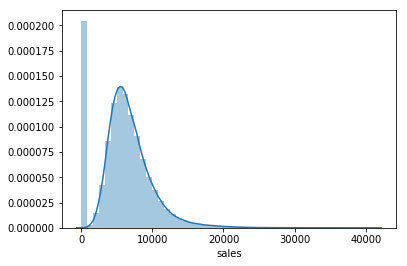

In [34]:
sns.distplot(df1['sales'])

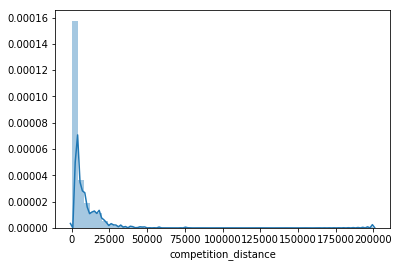

In [35]:
sns.distplot(df1['competition_distance'])

### 1.7.2. Categorical Attributes

** Um detalhe para projetos futuros seria renomear os valores das variaveis categoricasja aqui e não na etape da feature engineering.

In [36]:
cat_attributes.apply(lambda x: x.unique().shape)

,state_holiday,store_type,assortment,promo_interval,month_map
0,4,4,3,4,12


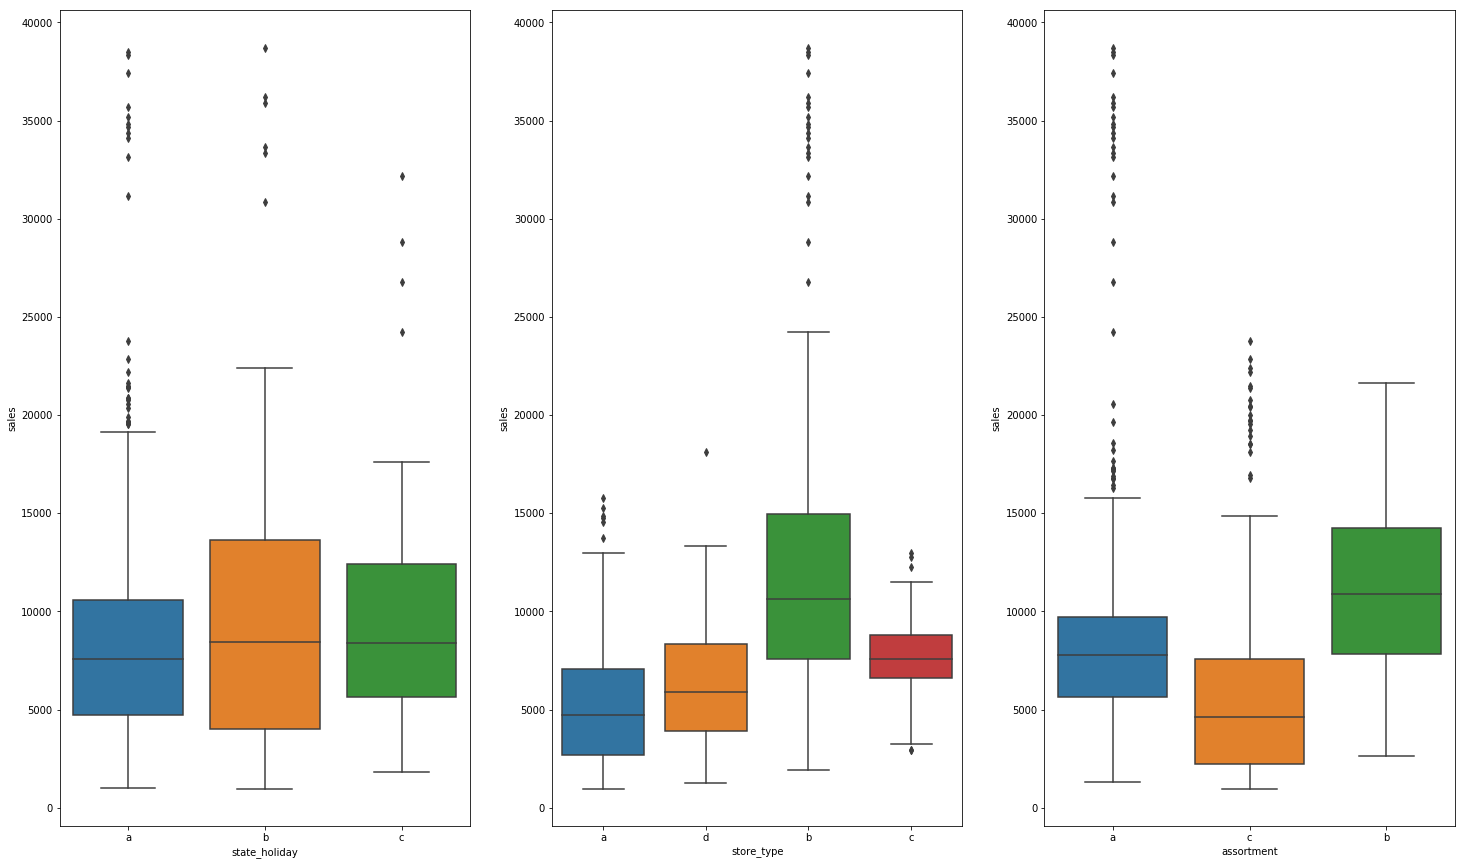

In [37]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.figure(figsize=(25, 15))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2. Feature Engineering

## Cicle

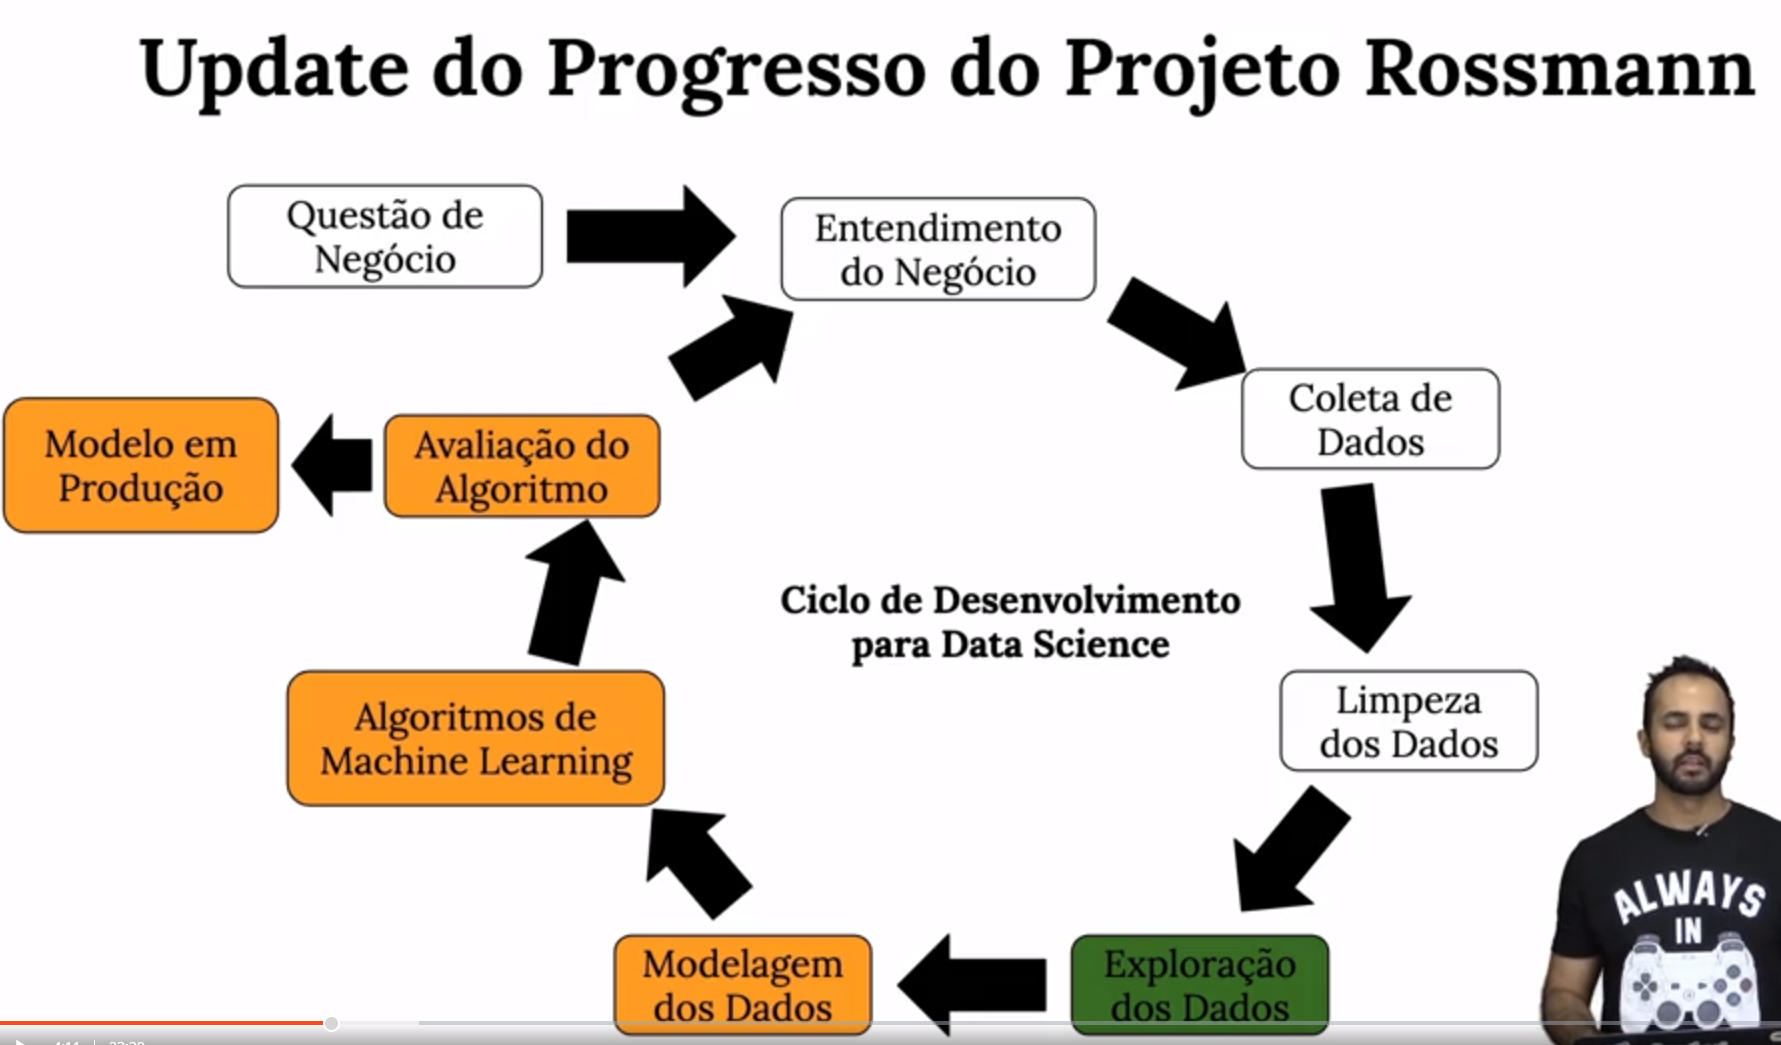

In [38]:
Image('Img/01.png')

## 2.1. Mind Map and Hypothesis creation

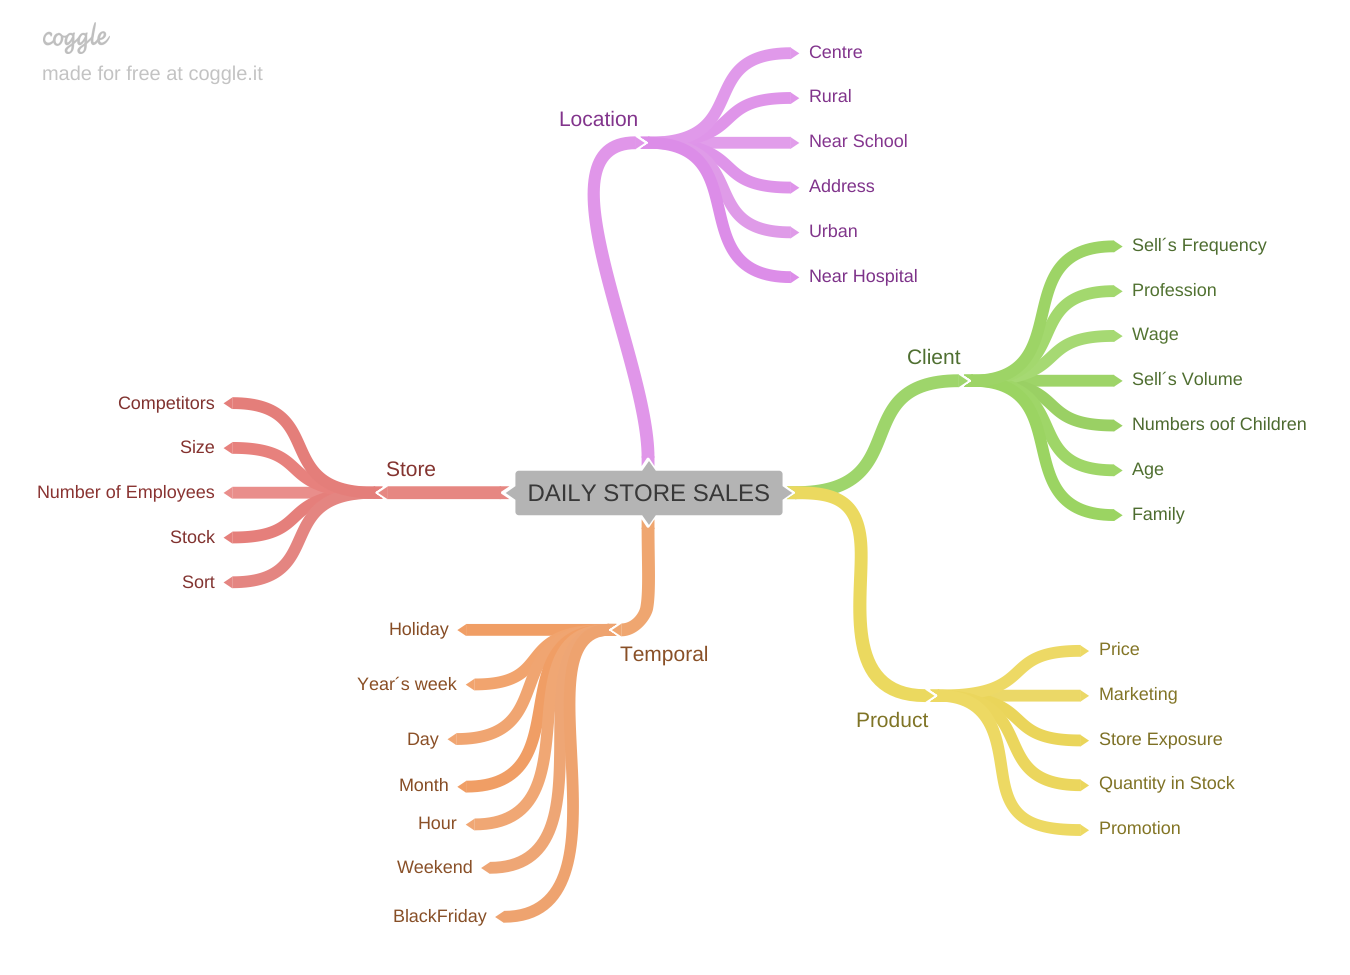

In [39]:
Image('Img/mindmap.png')

### 2.1.1. Store Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com mais sortimento deveriam vender mais

**5.** Lojas com mais competidores proximos deveriam vender menos

**6.** Lojas com mais competidores a mais tempo deveriam vender mais

### 2.1.2. Product Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expôem mais o produto deveriam vender mais

**3.** Lojas com produtos com preços menores deveriam vender mais

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais

**5.** Lojas com promoções ativas por mais tempos deveriam vender mais

**6.** Lojas com mais dias de promoções deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3. Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas  deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares


## 2.2. Final hypothesis list

4. Lojas com mais sortimento deveriam vender mais
5. Lojas com mais competidores proximos deveriam vender menos
6. Lojas com mais competidores a mais tempo deveriam vender mais

5. Lojas com promoções ativas por mais tempos deveriam vender mais

6. Lojas com mais dias de promoções deveriam vender mais

7. Lojas com mais promoções consecutivas deveriam vender mais

1. Lojas abertas durante o feriado de Natal deveriam vender mais

2. Lojas deveriam vender mais ao longo dos anos

3. Lojas deveriam vender mais no segundo semestre do ano

4. Lojas deveriam vender mais depois do dia 10 de cada mês

5. Lojas deveriam vender menos aos finais de semana

6. Lojas deveriam vender menos durante os feriados escolares

## 2.3. Feature Engineering

In [40]:
df2 = df1.copy()

In [41]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [42]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of the year
df2['week_of_the_year'] = df2['date'].dt.isocalendar().week
# year - week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [43]:
# competition since --> creating a variable for the time passed since the competition started 
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'] , day=1), axis=1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

In [44]:
# promo since --> creating a variable for the time passed since the promotion started
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

In [45]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

In [46]:
# state holiday
df2['state_holiday'] =  df2['state_holiday'].apply(lambda x: 'Public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x =='c' else 'Regular day')

In [47]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,Regular day,Regular day,Regular day,Regular day,Regular day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3. Data Filter

In [48]:
df3 = df2.copy()

In [49]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_the_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,Regular day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,Regular day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,Regular day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,Regular day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,Regular day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3. Rows Filtering

In [50]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3. Columns Filter

In [51]:
# customers is unnecessary due to unpredictability
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [52]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_the_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4. EDA

* Como as variaveis impactam o fenômeno? e qual a magnitude desse impacto? variáveis importantes para o modelo.
* Os 3 Objetivos da análise exploratória de dados:

**1.** Adquirir experiência de negócio.

**2.** Validar hipóteses de negócio (Insights).

**3.** Perceber as variáveis que são importantes para o modelo.

* Tipos de análise:

**1.** Análise univariada: Como é essa variável (min, max, distribuição, range...)

**2.** Análise multivariada: Como a variável impacta na resposta? (correlação, validação de hipóteses...)

**3.** Análise univariada: Como as variáveis se relacionam? 

In [69]:
df4 = df3.copy()

In [70]:
df4.to_csv('csv/df4.csv', index=False)

In [4]:
df4 = pd.read_csv('csv/df4.csv')

In [92]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_the_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,Regular day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,Regular day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,Regular day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,Regular day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,Regular day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1. Univariate analysis

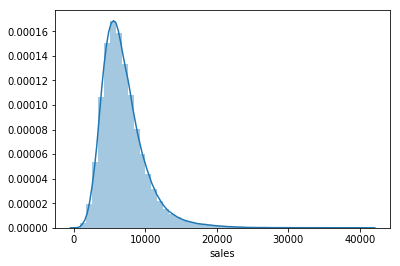

In [55]:
sns.distplot(df4['sales'])

### 4.1.1. Response variable

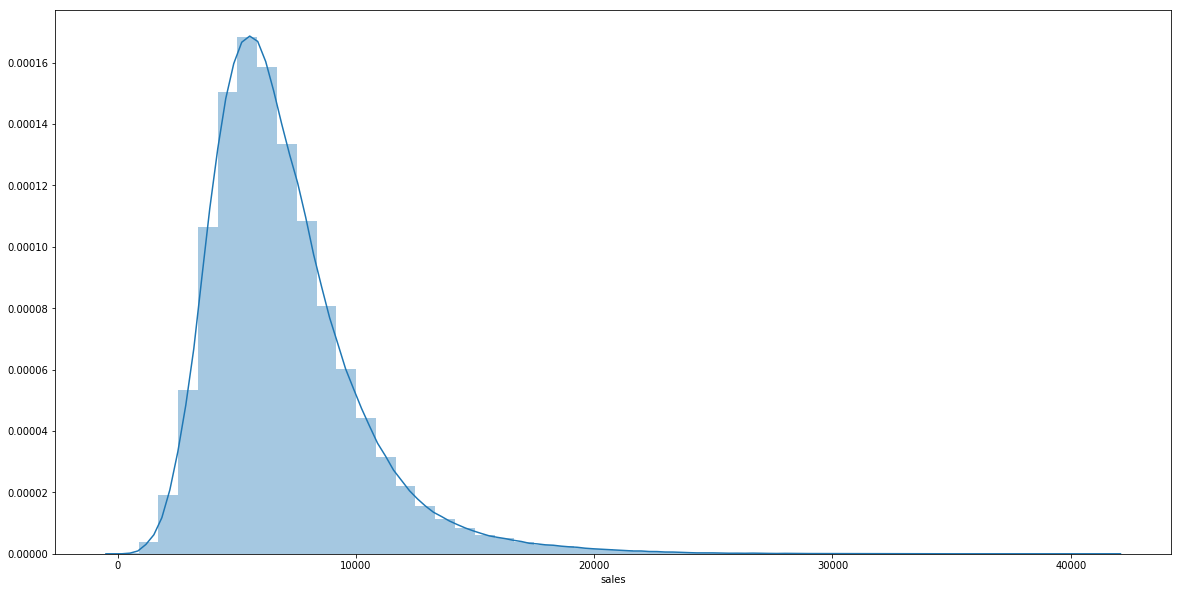

In [56]:
plt.figure(figsize=(20, 10))
sns.distplot(df4['sales'])

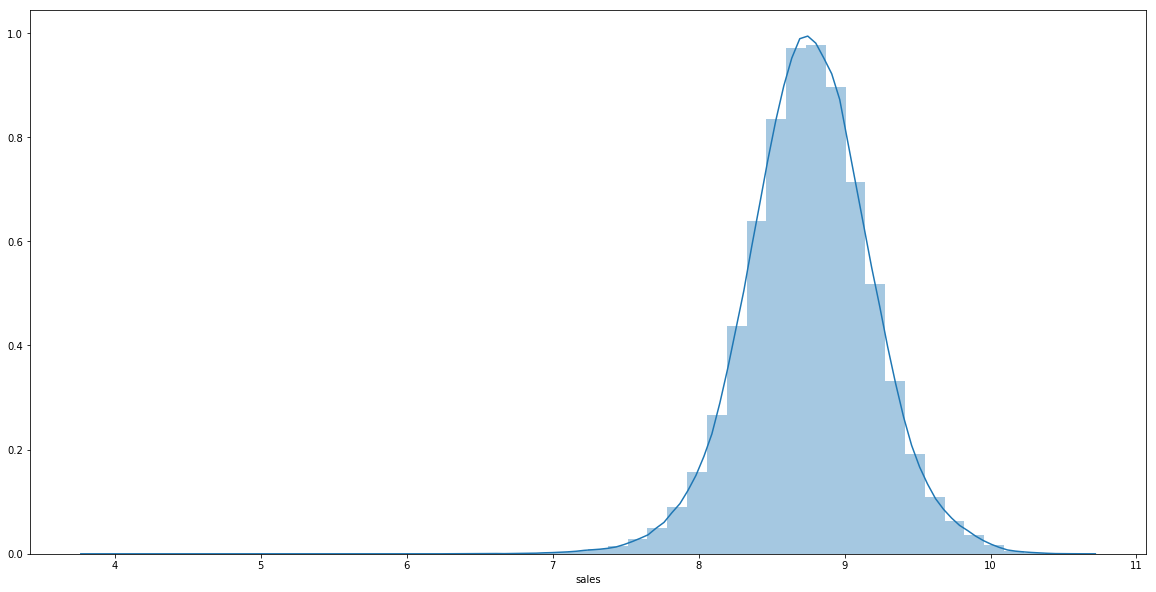

In [57]:
plt.figure(figsize=(20, 10))
sns.distplot(np.log1p(df4['sales']))

In [58]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_the_year                        UInt32
year_week                               object
competition_s

In [59]:
num_attributes = df4.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]', 'UInt32'])

### 4.1.2. Numerical variables

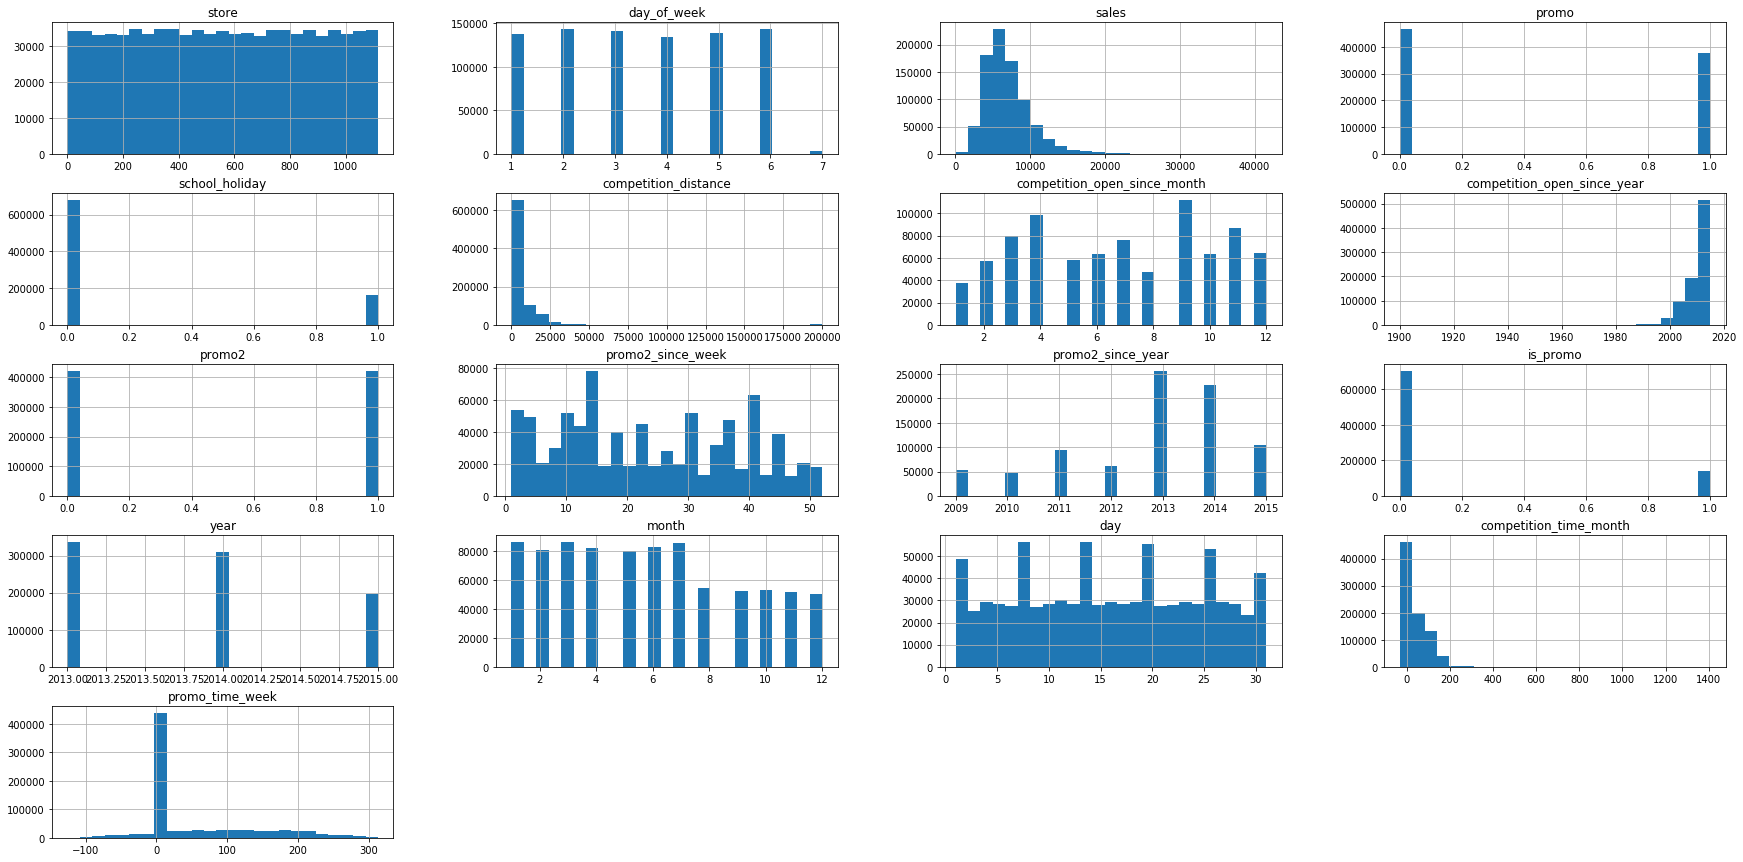

In [60]:
num_attributes.hist(figsize=(30,15), bins=25);

### 4.1.3. Categorical variables

In [61]:
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,Regular day,c,basic,2015-30
1,Regular day,a,basic,2015-30
2,Regular day,a,basic,2015-30
3,Regular day,c,extended,2015-30
4,Regular day,a,basic,2015-30


In [62]:
df4['state_holiday'].drop_duplicates()

0            Regular day
63559     Public holiday
129424    Easter holiday
241126         Christmas
Name: state_holiday, dtype: object

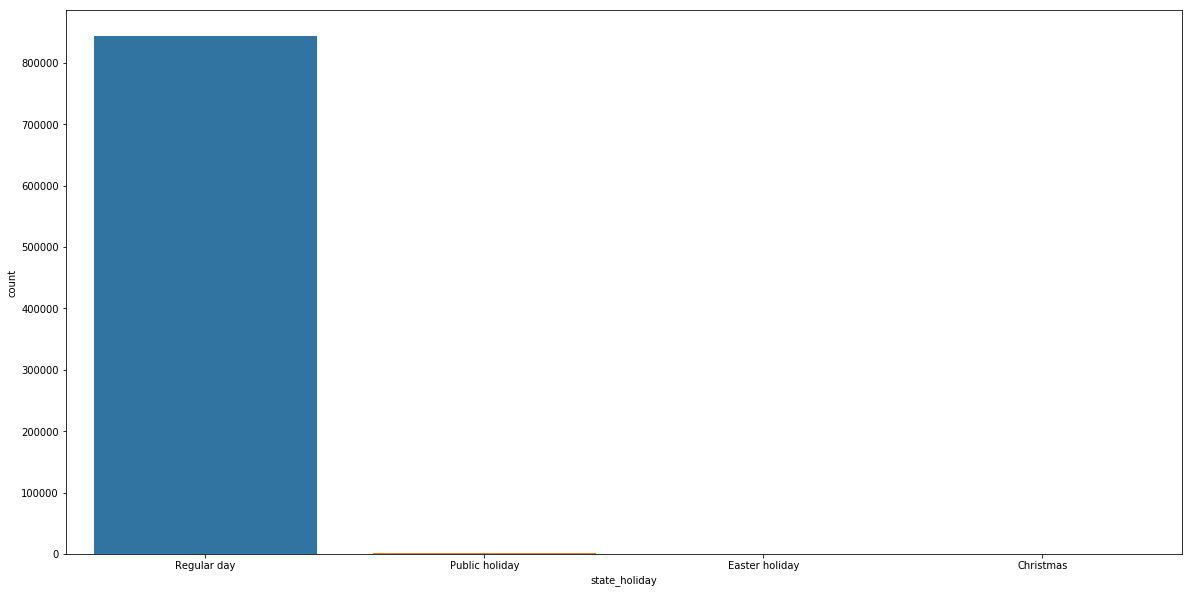

In [75]:
# state_holiday
plt.figure(figsize=(20, 10))
sns.countplot(df4['state_holiday'])

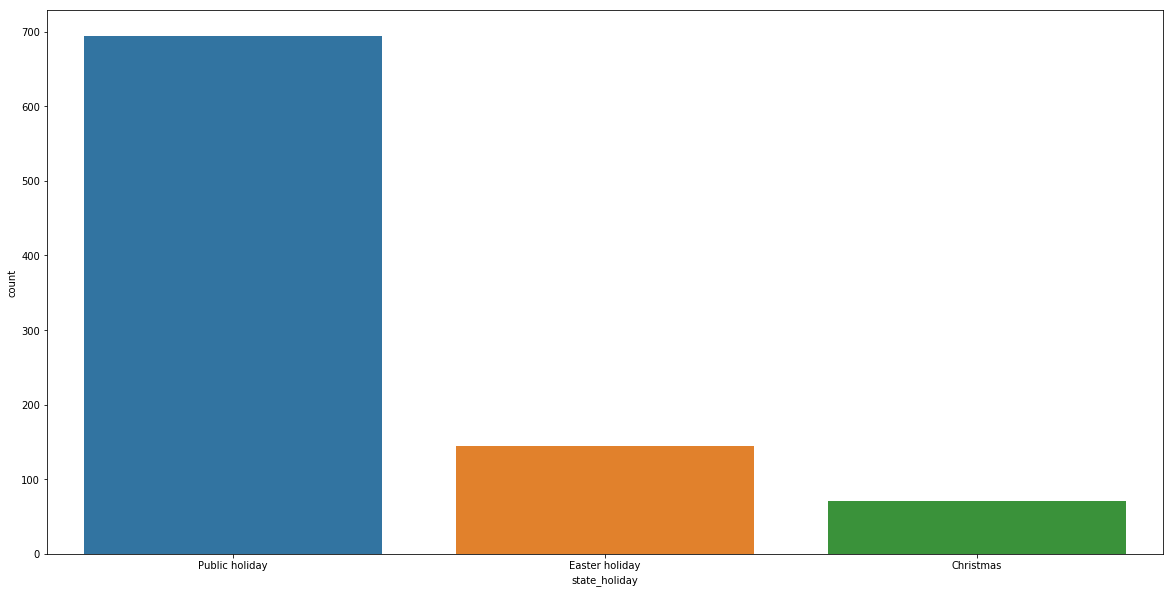

In [78]:
# state_holiday
a = df4[df4['state_holiday'] != 'Regular day']
plt.figure(figsize=(20, 10))
sns.countplot(a['state_holiday'])

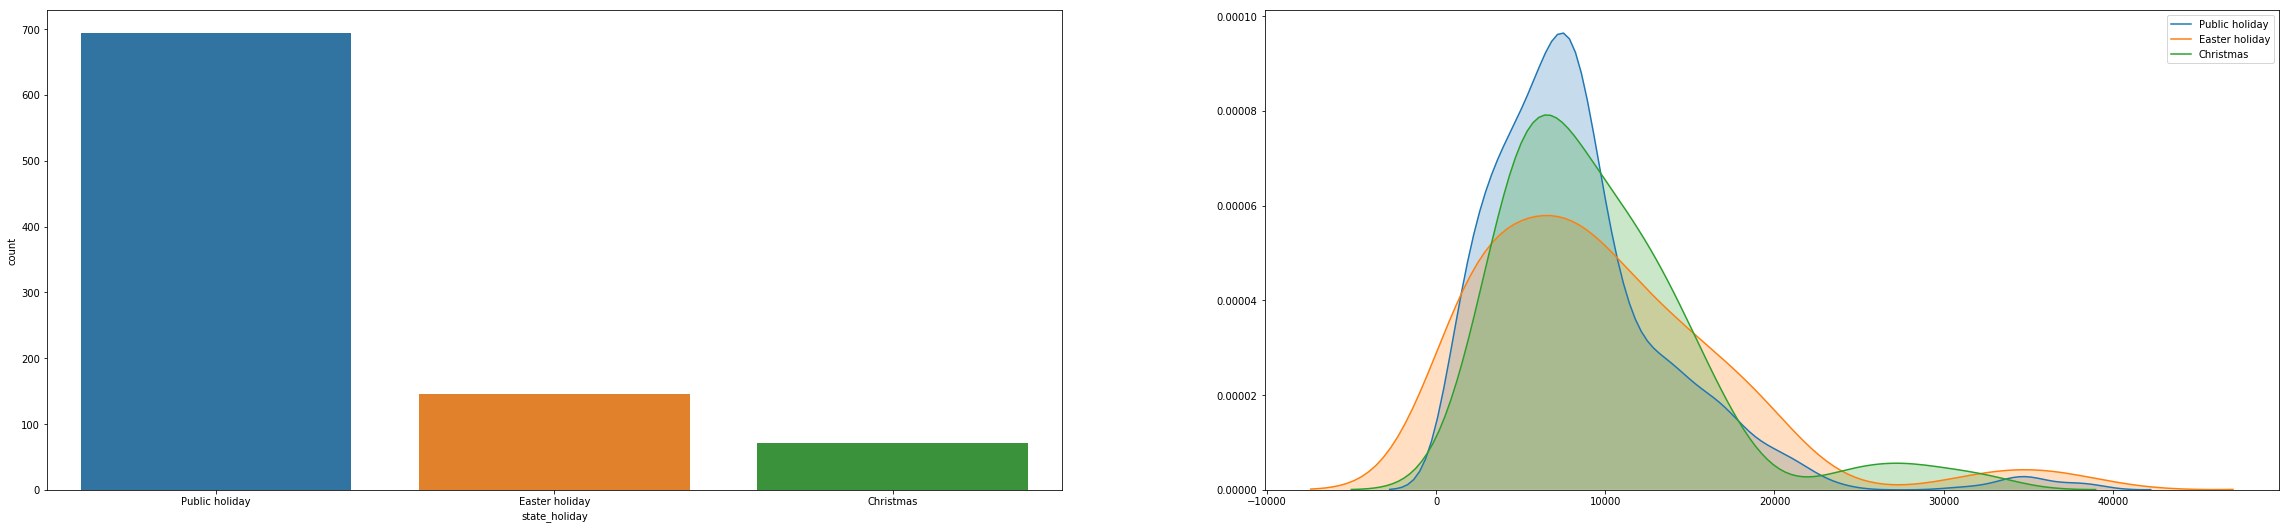

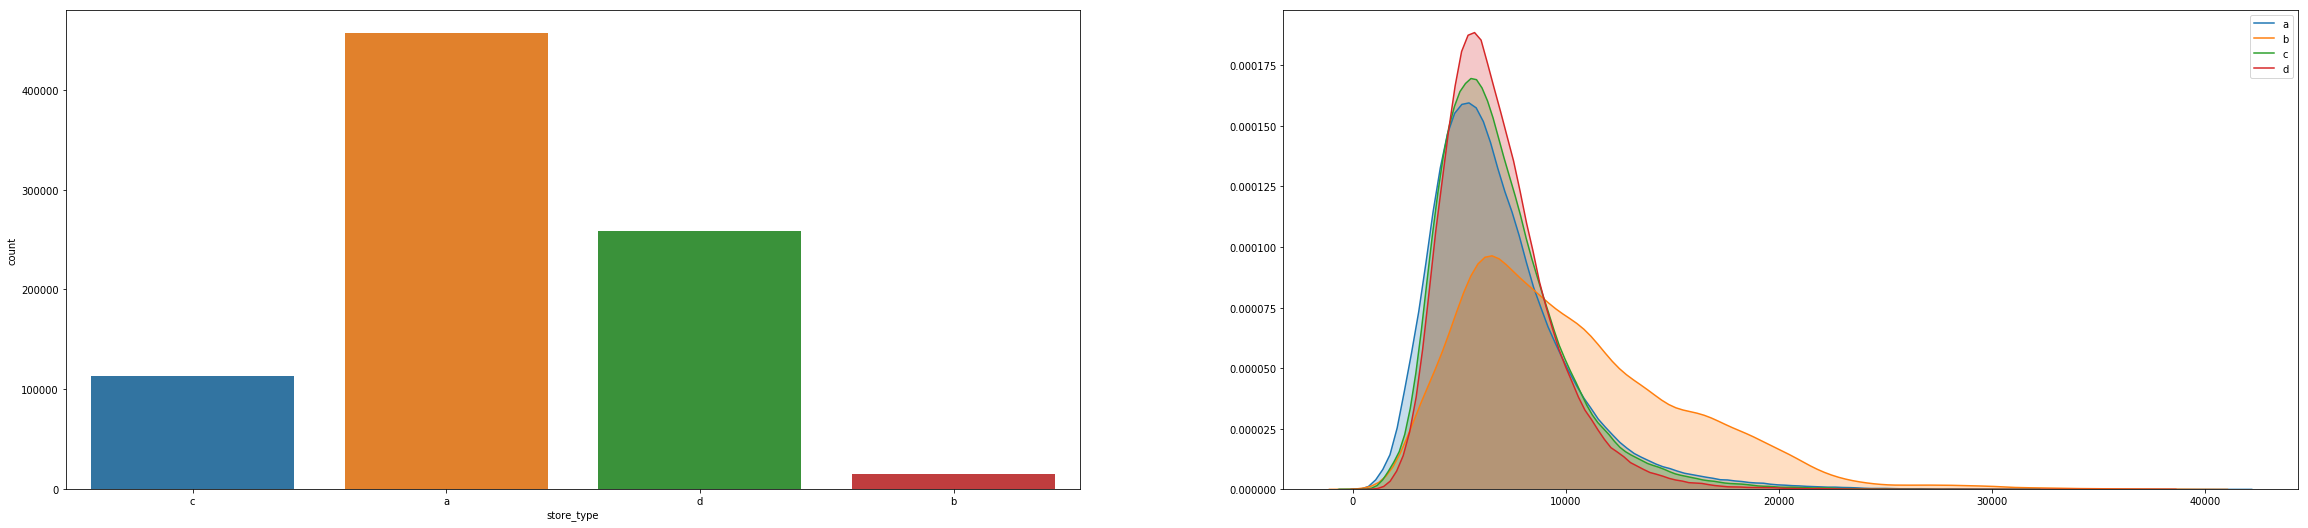

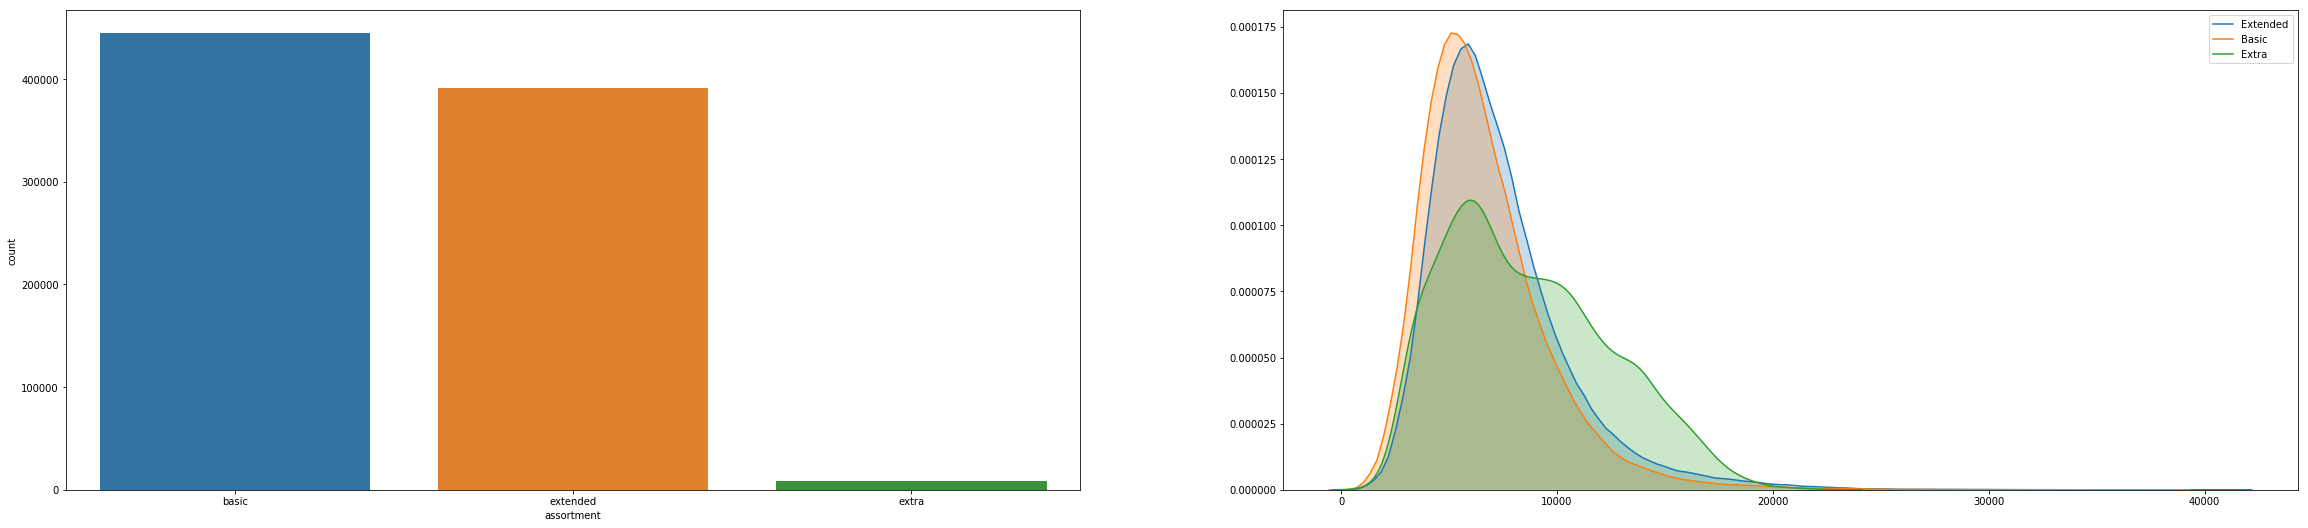

In [87]:
# state_holiday
plt.figure(figsize=(40, 30))

plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'Regular day']
sns.countplot(a['state_holiday'])

plt.subplot( 3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'Public holiday']['sales'], label='Public holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Easter holiday']['sales'], label='Easter holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade=True)

# Store type
plt.figure(figsize=(40, 30))

plt.subplot( 3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot( 3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.figure(figsize=(40, 30))

plt.subplot( 3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot( 3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='Extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='Basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='Extra', shade=True)

## 4.2. Bivariate analysis

### H1. stores with higher sortiment should be selling more

* Relative to other types of sortiment, the 'extra', which is considered the ones with highest sortiment, sell more. But in relation to the total of sell, it sells less then others.

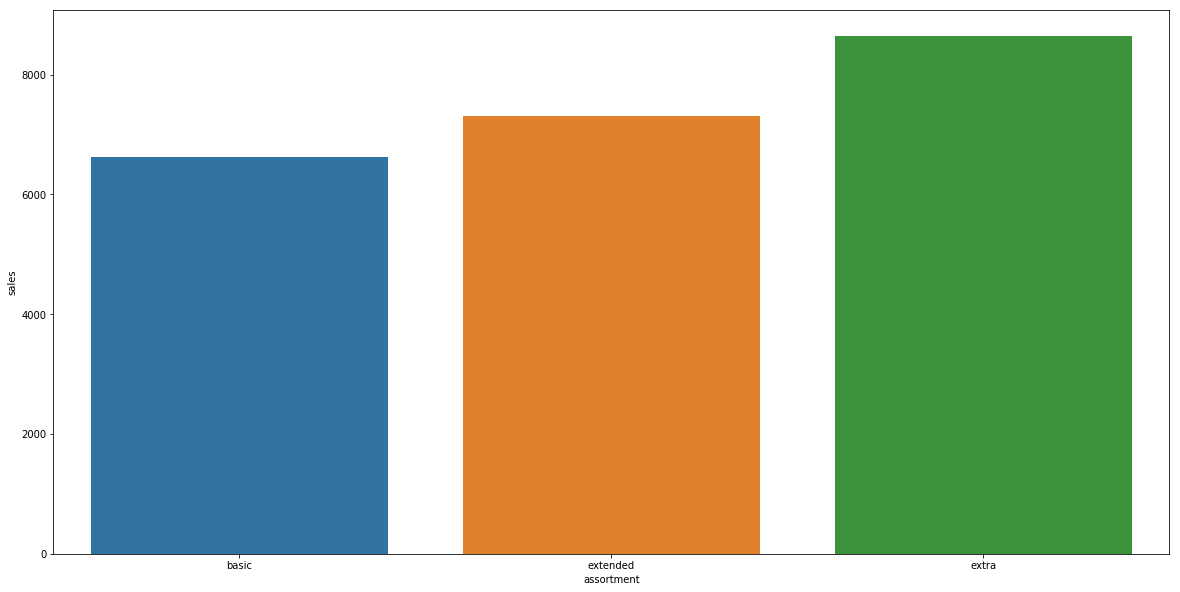

In [118]:
# assortment 'extra' sells more relative to other assortments, but less in total, for being a minority in the assortment category.
aux1_mean = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
plt.figure(figsize=(20,10))
sns.barplot(x='assortment', y='sales', data=aux1_mean)

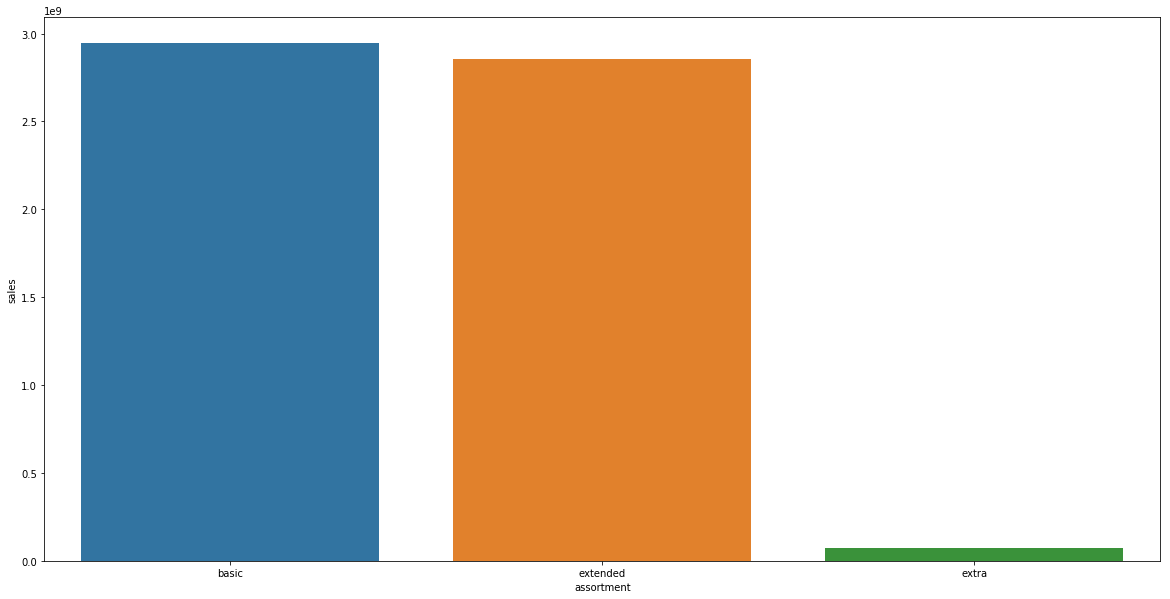

In [138]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
plt.figure(figsize=(20,10))
sns.barplot(x='assortment', y='sales', data=aux1)

In [120]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


In [129]:
aux2.pivot(index='year_week', columns='assortment', values='sales')

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061
...,...,...,...
2015-26,27840342,27165959,684180
2015-27,20356210,20449036,586036
2015-28,25746704,25629698,632017


In [139]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061
...,...,...,...
398,2015-26,extra,684180
401,2015-27,extra,586036
404,2015-28,extra,632017
407,2015-29,extra,574020


<Figure size 1440x720 with 0 Axes>

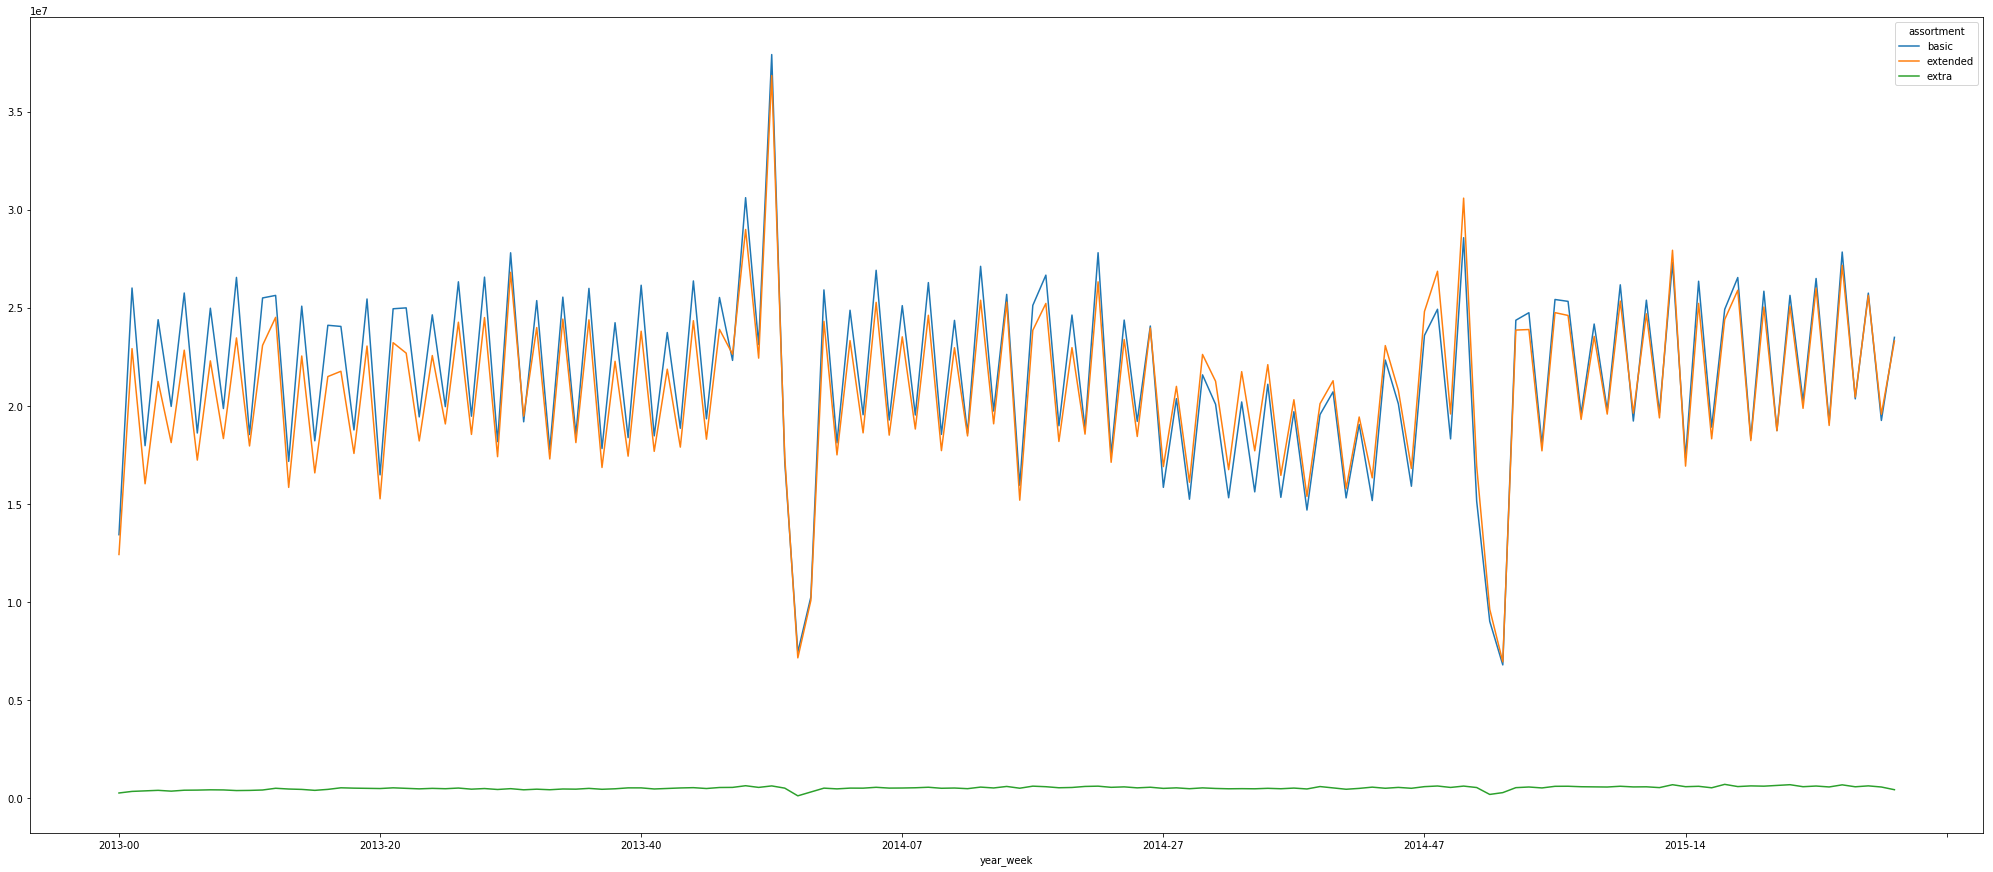

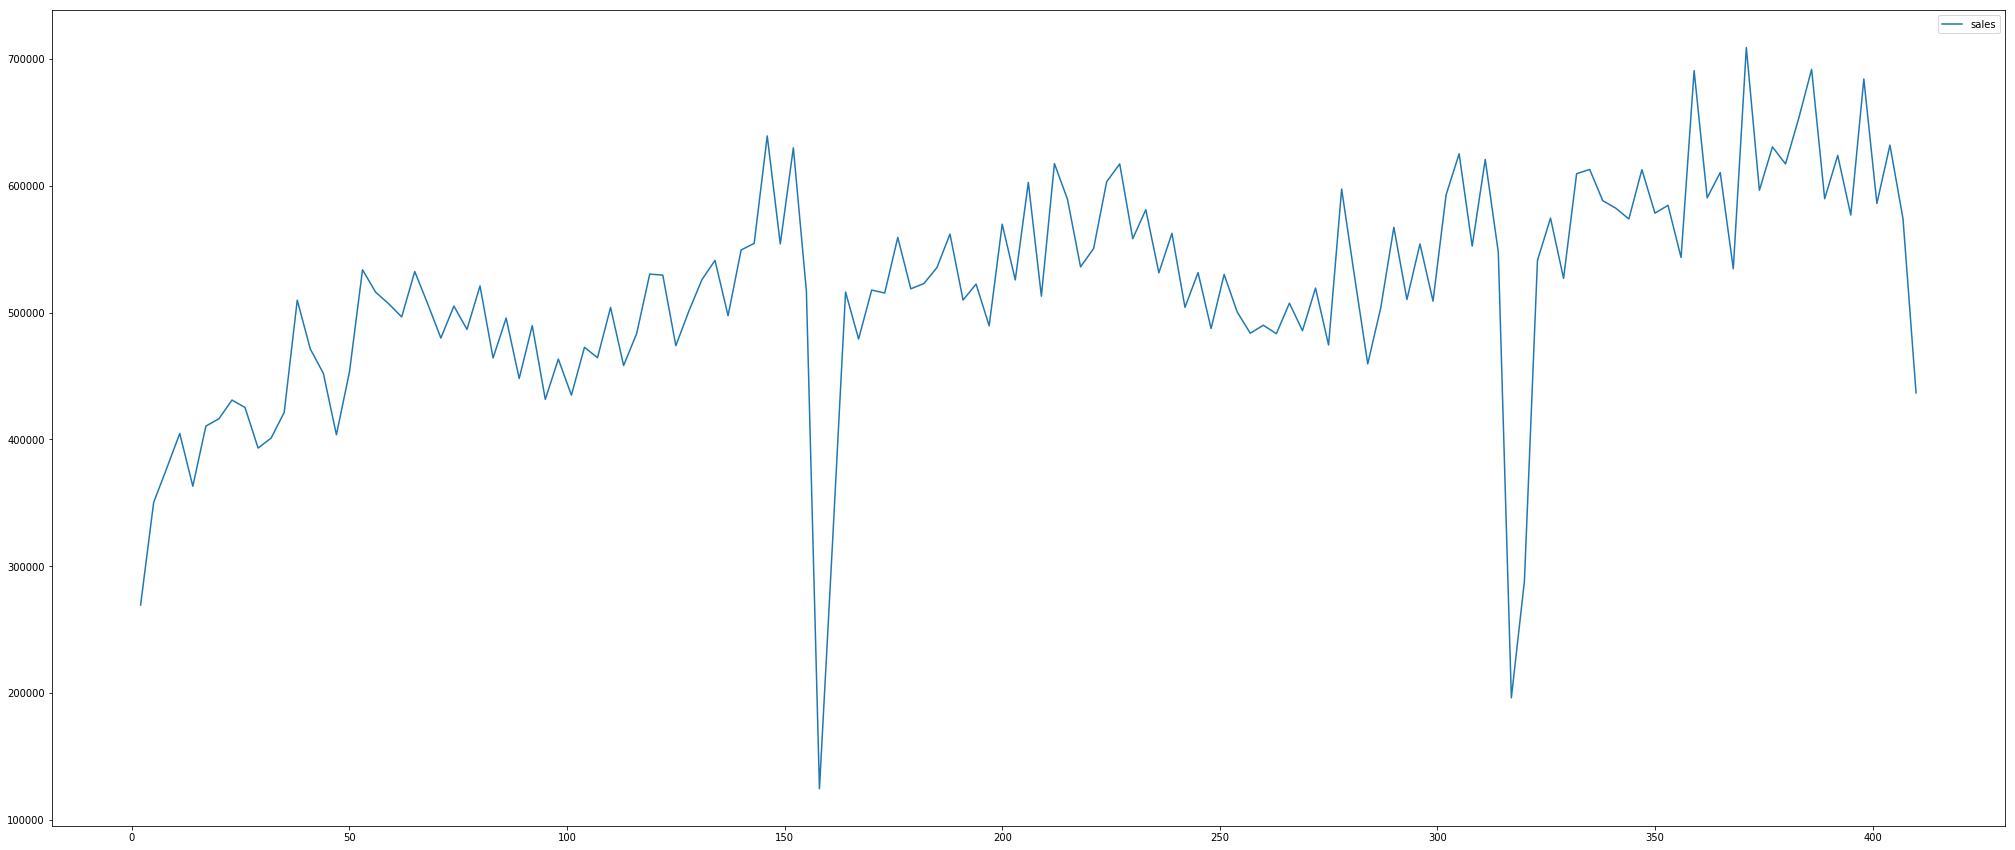

In [140]:
plt.figure(figsize=(20,10))
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(35,15))
aux3.plot(figsize=(35,15))

### H2. Stores with closest competitors should be selling less

* FALSE, the closest the competition is of the store, the more it sells.

In [ ]:
df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

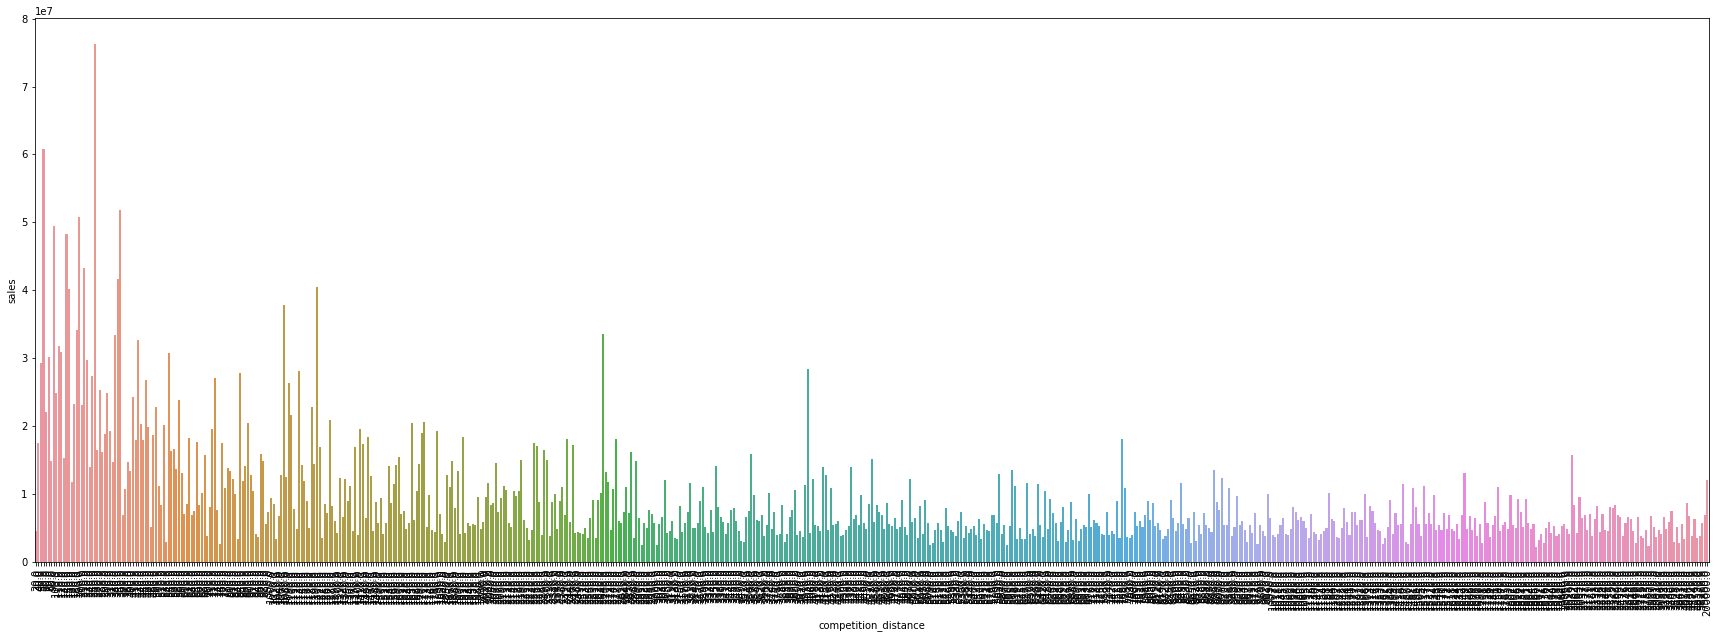

In [30]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
sns.barplot(x='competition_distance', y='sales', data=aux1)

# Dados muito grranulares ficam desagradáveis de visualizar

In [17]:
df4['sales']

0          5263
1          6064
2          8314
3         13995
4          4822
          ...  
844333     3375
844334    10765
844335     5035
844336     4491
844337     5961
Name: sales, Length: 844338, dtype: int64

In [12]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux1.sample(5)

# plt.figure(figsize=(30,10))
# sns.barplot(x='competition_distance', y='sales', data=aux1)

,competition_distance,sales,competition_distance_binned
308,4140.0,14002538,"(4000.0, 5000.0]"
617,23130.0,7973232,NaN
482,9910.0,10039865,"(9000.0, 10000.0]"
433,7930.0,5151315,"(7000.0, 8000.0]"
52,540.0,30697646,"(0.0, 1000.0]"


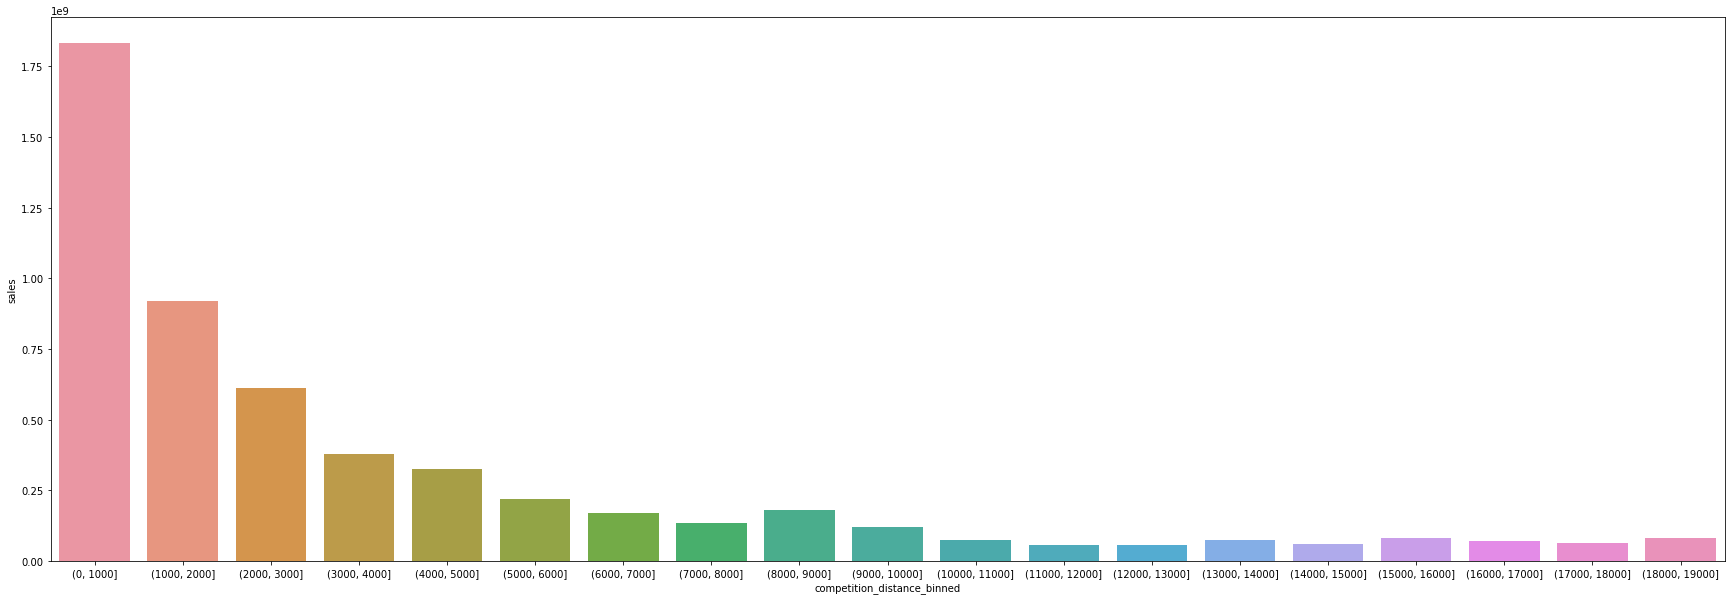

In [19]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.figure(figsize=(30,10))
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)

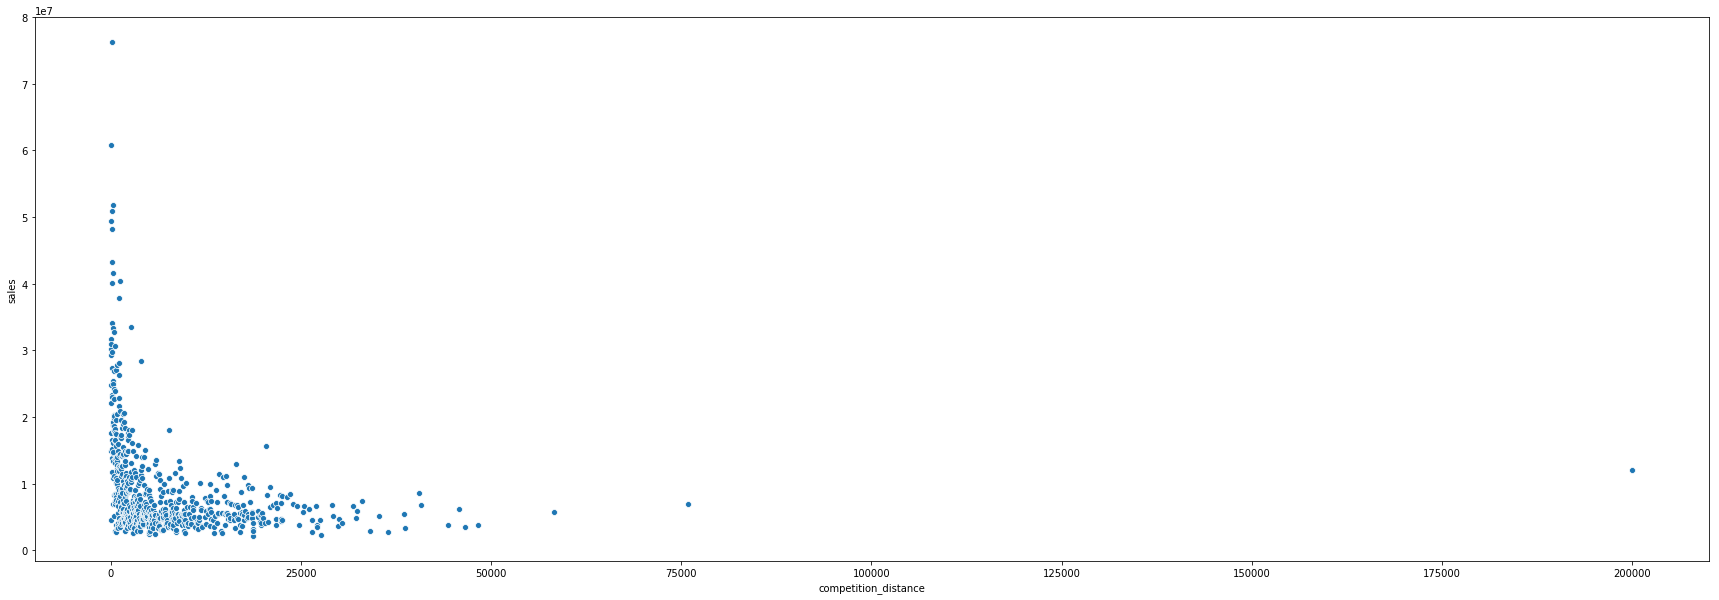

In [21]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(30,10))
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
# bins = list(np.arange(0,20000,1000))
# aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
# aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
# plt.figure(figsize=(30,10))
# sns.barplot(x='competition_distance_binned', y='sales', data=aux2)

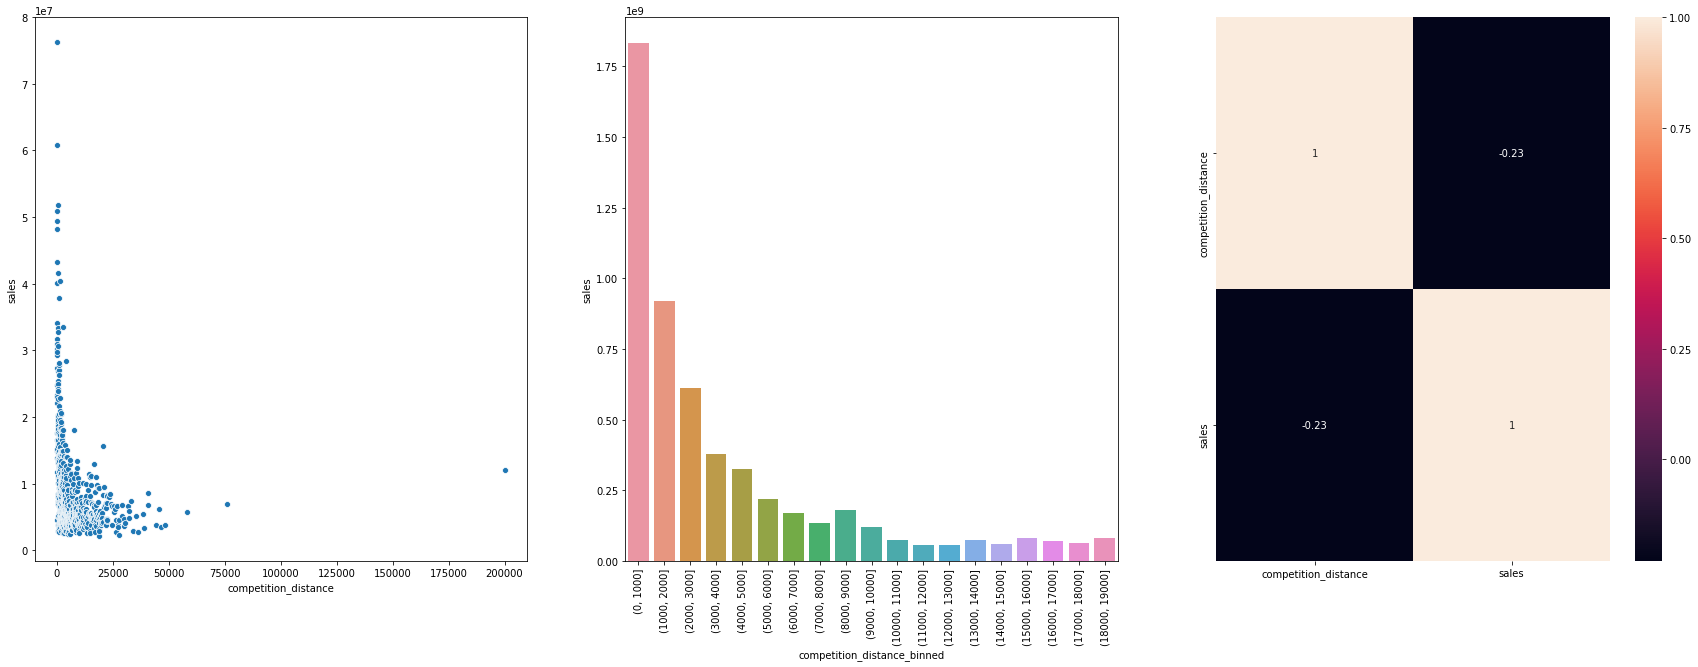

In [28]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Stores with older competitors should sell more

* FALSE, the earliest the time of competition opening, the more the store tends to sell.

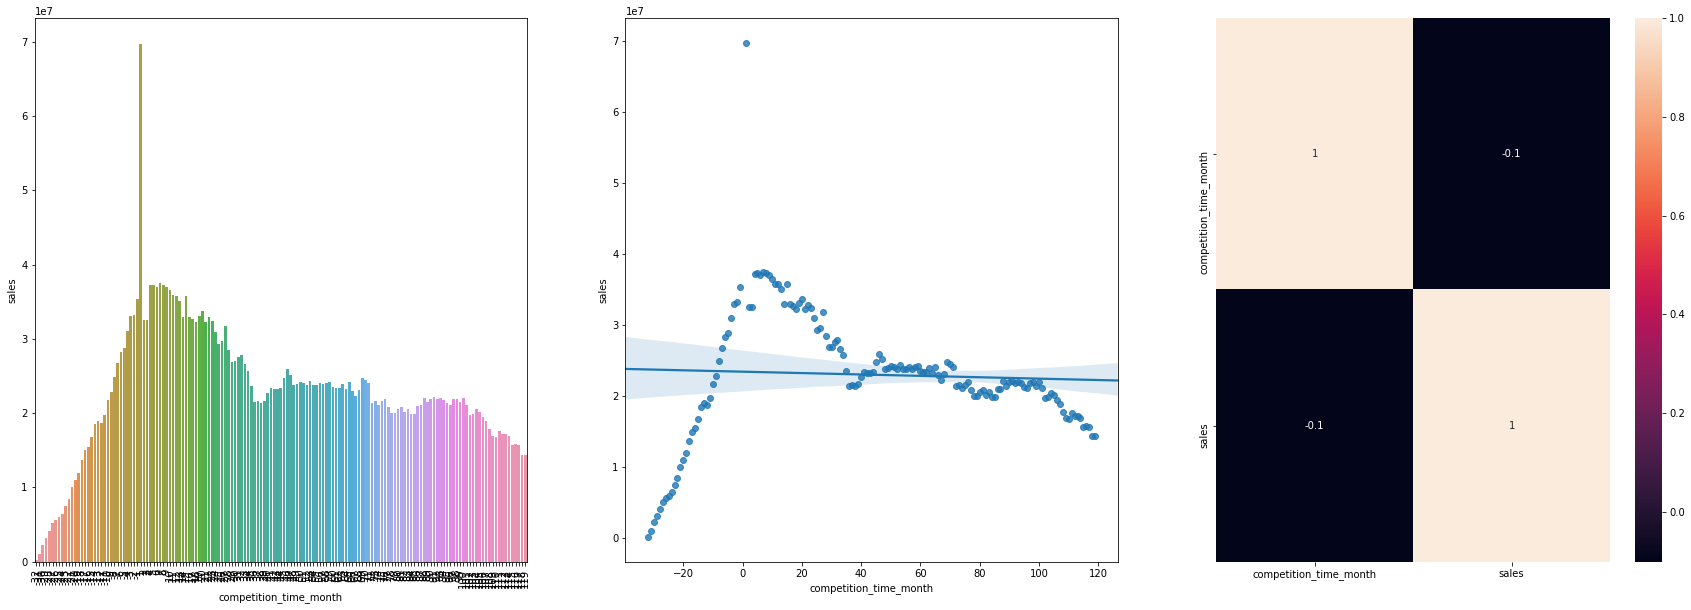

In [46]:
plt.figure(figsize=(30,10))
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot(1,3,1)
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)

# 5. Data Preparation

In [48]:
df5 = df4.copy()

In [50]:
df5.to_csv('csv/df5.csv', index=False)

# 6. Feature Selection

# 7. ML models

# 8. Hyperparameter Fine Tuning

# 9. Error interpretation

# 10. Model Deploy

# 11. Telegram Bot